In [ ]:
import os
import pandas as pd
import geopandas as gpd
import xarray as xr
import math
import rasterio
from rasterio.merge import merge
from rasterio.io import MemoryFile
import numpy as np
from rasterio.io import MemoryFile
from rasterio.windows import Window

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# 4. Build ML models to predict whether a pixel is ignited

In [3]:
folder = '../../climada_petals/data/wildfire/output/2013/'
df = gpd.read_file(os.path.join(folder, 'ignited_eu_2013_gdf'))
df

,latitude,longitude,brightness,confidence,bright_t31,fwi,distance_km,date,ignited,land_cover,elevation,geometry
0,35.8073,-0.2538,310.2,79,277.6,6.847656,6.380693,2013-01-01,True,50,16,POINT (-0.25380 35.80730)
1,47.8587,33.4466,308.0,63,272.6,0.214844,12.727889,2013-01-01,True,50,110,POINT (33.44660 47.85870)
2,49.6728,18.6611,307.4,57,276.5,1.417969,10.702774,2013-01-01,True,50,319,POINT (18.66110 49.67280)
3,37.3934,39.4902,303.1,55,287.0,3.445312,11.884926,2013-01-01,True,40,705,POINT (39.49020 37.39340)
4,36.8729,6.9397,320.8,75,286.9,3.714844,14.682411,2013-01-01,True,50,2,POINT (6.93970 36.87290)
...,...,...,...,...,...,...,...,...,...,...,...,...
159648,48.5000,-20.7500,303.1,47,288.5,NaN,1511.020307,2013-10-25,False,200,0,POINT (-20.75000 48.50000)
159649,42.7500,4.2500,307.0,70,288.1,NaN,93.131421,2013-10-05,False,200,0,POINT (4.25000 42.75000)
159650,54.7500,-20.2500,305.0,60,287.2,NaN,2241.524404,2013-01-25,False,200,0,POINT (-20.25000 54.75000)
159651,51.5000,-29.5000,309.9,79,287.5,NaN,1948.420714,2013-08-17,False,200,0,POINT (-29.50000 51.50000)


In [4]:
df['ignited'].value_counts()

ignited
False    86148
True     73505
Name: count, dtype: int64

## 4.1 Preprocessing Data

### Check whether longitude is in the correct range

In [4]:
df_false = df[df['ignited'] == False].sample(n=10000, replace=False, random_state=42)
df_false['longitude'].describe()

count    10000.000000
mean         4.427250
std         20.769574
min        -31.000000
25%        -13.750000
50%          4.500000
75%         22.250000
max         40.000000
Name: longitude, dtype: float64

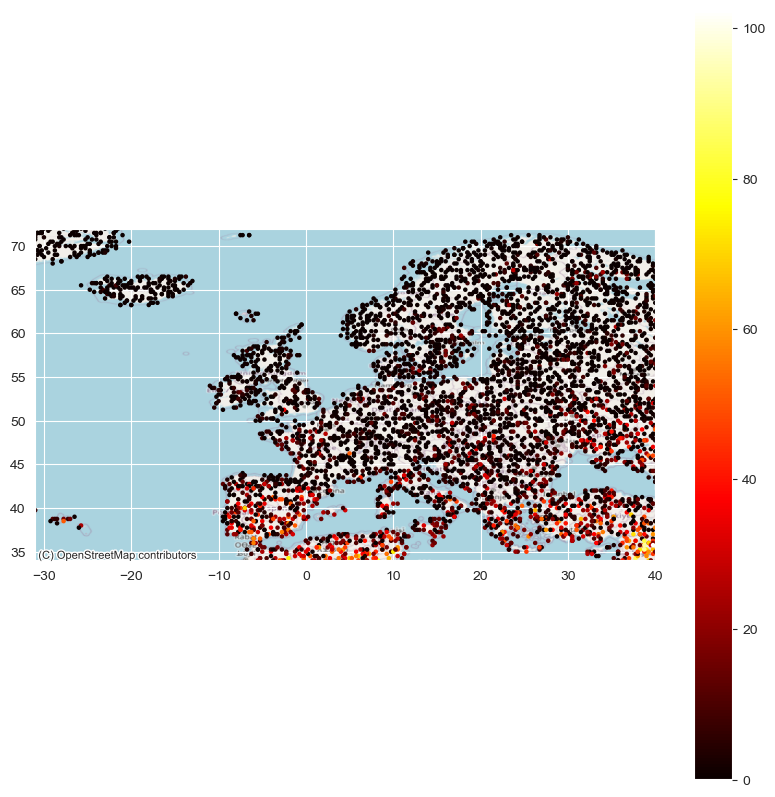

In [5]:
import contextily as ctx
import matplotlib.pyplot as plt

geo_bound_eu = (-31, 34, 40 ,72)
fig, ax = plt.subplots(figsize=(10, 10))
df_false.plot(ax=ax, column='fwi', legend=True, cmap='hot', markersize=5)
ax.set_xlim(geo_bound_eu[0], geo_bound_eu[2])
ax.set_ylim(geo_bound_eu[1], geo_bound_eu[3])
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

### Map land cover to fire ignition probability

In [5]:
# Map land cover type to ignition probability according to Climada Master thesis Table 2.1
# and Land Cover User Manual Table 4 Discrete classification coding
# land_cover_map_dict = {
#     0: 0, # no input data
#     111: 1, 113: 1, 112: 1, 114: 1, 115: 1, 116: 1, 121: 1, 123: 1, 122: 1, 124: 1, 125: 1, 126: 1, # forest
#     20: 1, # shrubs
#     30: 1, # Herbaceous vegetation
#     90: 0.85, # Herbaceous wetland
#     100: 1, # Moss and lichen
#     60: 0, # Bare / sparse vegetation
#     40: 0, # cropland
#     50: 0, # Urban / built up
#     70: 0, # Snow and ice
#     80: 0, # permanent water bodies 
#     200: 0, # open sea
# }
# 
# df['land_cover'] = df['land_cover'].map(land_cover_map_dict)
# df['land_cover'].value_counts()
# df.rename(columns={'land_cover': 'ignition_probability'}, inplace=True)

land_cover
0.00    111912
1.00     46673
0.85      1068
Name: count, dtype: int64

In [ ]:
# Run this code instead if you don't want to map land cover to ignition probability
# one hot encode land cover
df = pd.get_dummies(df, columns=['land_cover'], prefix='land_cover')


### Only retain month for date column then take sin and cos

In [8]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract the month from the 'date' column
df['month'] = df['date'].dt.month

In [9]:
print(df['month'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12]


In [10]:
# Create 'month_sin' and 'month_cos' columns
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df = df.drop(columns=['month', 'date', 'distance_km', 'confidence', 'geometry'])

### Make sure there is no NA values

In [11]:
df.isna().sum()

latitude                    0
longitude                   0
brightness                  0
bright_t31                  0
fwi                     42959
ignited                     0
ignition_probability        0
elevation                   0
month_sin                   0
month_cos                   0
dtype: int64

In [12]:
df['fwi'].fillna(0, inplace=True)

## Training ML models with Optuna optimization and Cross Validation

In [13]:
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

### Train test split

In [21]:
# # Random split
# X_train_val, X_test, y_train_val, y_test = train_test_split(df.drop(columns=['ignited']), df['ignited'], test_size=0.1, random_state=42, shuffle=True)
# print(X_train_val.shape, X_test.shape)

In [14]:
# Use France as test set and rest of EU as training set
GEO_BOUND_FRANCE = (-5, 41, 10, 51)
france_mask = (df['longitude'] >= GEO_BOUND_FRANCE[0]) & (df['longitude'] <= GEO_BOUND_FRANCE[2]) & (df['latitude'] >= GEO_BOUND_FRANCE[1]) & (df['latitude'] <= GEO_BOUND_FRANCE[3])

In [16]:
X = df.drop(columns=['ignited'])
y = df['ignited']
X_train_val, X_test = X[~france_mask], X[france_mask]
y_train_val, y_test = y[~france_mask], y[france_mask]
print(X_train_val.shape, X_test.shape)

(152288, 9) (7365, 9)


In [ ]:
X.columns

In [ ]:
# Run this code if you need to exclude latitude, longitude, brightness, bright_t31
X_train_val = X_train_val.drop(columns=['latitude', 'longitude', 'brightness', 'bright_t31'])
X_test = X_test.drop(columns=['latitude', 'longitude', 'brightness', 'bright_t31'])

### Hyperparameter tuning with Optuna and cross validation

In [18]:


classifier_names = ["LogisticRegression", "XGBClassifier"]

# Create dictionaries to store the best models, hyperparameters, and scores for each ML model
best_models = {}
best_params = {}
best_scores = {}

for name in classifier_names:
    best_scores[name] = 0
    best_params[name] = None
    best_models[name] = None

In [22]:
# function for both Logistic Regression and XGBoost
def logisticregression_objective(trial):
    classifier_name = "LogisticRegression"
    logistic_c = trial.suggest_float('logistic_c', 1e-5, 1e5, log=True)
        
    classifier_obj = LogisticRegression(C=logistic_c, random_state=42)
    # Create a pipeline with a scaler and the updated model
    model_pipeline = make_pipeline(StandardScaler(), classifier_obj)

    # Perform cross-validation
    score = cross_val_score(model_pipeline, X_train_val, y_train_val, cv=5, n_jobs=-1, scoring='roc_auc').mean() # may also use: scoring='accuracy'
    
    if score > best_scores[classifier_name]:
        best_scores[classifier_name] = score
        best_params[classifier_name] = trial.params
        best_models[classifier_name] = classifier_obj # classifier_obj remain untrained
        
    return score
    
def xgboost_objective(trial):
    classifier_name = "XGBClassifier"
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42
    }
    classifier_obj = XGBClassifier(**xgb_params)
    model_pipeline = classifier_obj


    # Perform cross-validation
    score = cross_val_score(model_pipeline, X_train_val, y_train_val, cv=5, n_jobs=-1, scoring='roc_auc').mean() # scoring='accuracy'
    
    if score > best_scores[classifier_name]:
        best_scores[classifier_name] = score
        best_params[classifier_name] = trial.params
        best_models[classifier_name] = classifier_obj # classifier_obj remain untrained
        
    return score
    

In [23]:
study = optuna.create_study(sampler=optuna.samplers.GPSampler(), storage='sqlite:///db.sqlite3', direction='maximize')
study.optimize(logisticregression_objective, n_trials=20)

C:\Users\zhong\AppData\Local\Temp\ipykernel_13772\1077857829.py:1: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study = optuna.create_study(sampler=optuna.samplers.GPSampler(), storage='sqlite:///db.sqlite3', direction='maximize')
[I 2024-07-10 13:31:25,846] A new study created in RDB with name: no-name-c3484027-88d7-43c6-bbf7-6dc27284496d
[I 2024-07-10 13:31:31,612] Trial 0 finished with value: 0.6918866414088449 and parameters: {'classifier': 'XGBClassifier', 'n_estimators': 413, 'max_depth': 8, 'learning_rate': 0.0020622319763515472, 'subsample': 0.5016684183566094, 'colsample_bytree': 0.638709689721302, 'gamma': 3.180082637096184, 'reg_alpha': 0.5685797841707235, 'reg_lambda': 0.09110704903748434}. Best is trial 0 with value: 0.6918866414088449.
[I 2024-07-10 13:31:32,594] Trial 1 finished with value: 0.716340112476595 and parameters: {'classifier': 'LogisticRegression', 'logistic_c': 3.134079936649151e-05}. Best 

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.GPSampler(), storage='sqlite:///db.sqlite3', direction='maximize')
study.optimize(xgboost_objective, n_trials=100)

### Training accuracy, Test accuracy and F-1 score

In [28]:
# Run this code if you need to rerun training and test accuracy
# for name in classifier_names:
#     if name == 'XGBClassifier':
#         model = XGBClassifier(**best_params[name], random_state=42)
#     elif name == 'LogisticRegression':
#         model = LogisticRegression(C=best_params[name]['logistic_c'], random_state=42)
#     else:
#         raise ValueError("Invalid classifier name")

In [24]:


for name in classifier_names:
    print("Model:", name)
    print("Best hyperparameters:", best_params[name])
    
    if name == "LogisticRegression":
        # Increase max_iter in the LogisticRegression model
        best_models[name].set_params(max_iter=200)
        
        # Create a pipeline with a scaler and the updated model
        model_pipeline = make_pipeline(StandardScaler(), best_models[name])
    else:
        model_pipeline = best_models[name]

    # Fit the best model on the training data
    model_pipeline.fit(X_train_val, y_train_val)
    
    # Calculate the training accuracy
    train_accuracy = model_pipeline.score(X_train_val, y_train_val)
    print("Training accuracy:", train_accuracy)
    test_accuracy = model_pipeline.score(X_test, y_test)
    print("Test accuracy:", test_accuracy)
    y_pred = model_pipeline.predict(X_test)
    # Print the classification report
    print(classification_report(y_test, y_pred))
    # Print the confusion matrix
    print(confusion_matrix(y_test, y_pred))

Model: LogisticRegression
Best hyperparameters: {'classifier': 'LogisticRegression', 'logistic_c': 37991.56891411329}
Training accuracy: 0.8339790397142257
Test accuracy: 0.7167684996605567
              precision    recall  f1-score   support

       False       0.72      0.93      0.81      4858
        True       0.69      0.31      0.43      2507

    accuracy                           0.72      7365
   macro avg       0.70      0.62      0.62      7365
weighted avg       0.71      0.72      0.68      7365

[[4501  357]
 [1729  778]]
Model: XGBClassifier
Best hyperparameters: {'classifier': 'XGBClassifier', 'n_estimators': 1066, 'max_depth': 3, 'learning_rate': 0.001848780816760394, 'subsample': 0.7506647700182902, 'colsample_bytree': 0.7421229238108633, 'gamma': 4.301607911015463, 'reg_alpha': 0.7173397558462596, 'reg_lambda': 0.7857600690077732}
Training accuracy: 0.8982782622399664
Test accuracy: 0.7342837746096402
              precision    recall  f1-score   support

       Fa

### Feature importance

In [25]:
classifier_names

['LogisticRegression', 'XGBClassifier']

In [34]:
for name in classifier_names:
    if name == "LogisticRegression":
        reg_coff = best_models[name].coef_[0]
        feature_importance_df = pd.DataFrame({'feature': X_train_val.columns, 'coefficient': reg_coff})
        feature_importance_df = feature_importance_df.sort_values(by='coefficient', ascending=False)
        print(name)
        print(feature_importance_df)
        print('------------------------------------')
    elif name == "XGBClassifier":
        feature_importance = best_models[name].feature_importances_
        feature_importance_df = pd.DataFrame({'feature': X_train_val.columns, 'importance': feature_importance})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
        print(name)
        print(feature_importance_df)
        print('------------------------------------')

LogisticRegression
                feature  coefficient
4                   fwi     1.419565
1             longitude     1.141489
3            bright_t31     0.341207
7             month_sin     0.149550
5  ignition_probability     0.032137
2            brightness    -0.002037
8             month_cos    -0.077502
6             elevation    -0.249802
0              latitude    -0.437936
------------------------------------
XGBClassifier
                feature  importance
4                   fwi    0.343581
3            bright_t31    0.204192
6             elevation    0.203826
0              latitude    0.062939
1             longitude    0.056884
8             month_cos    0.050779
5  ignition_probability    0.033991
7             month_sin    0.024804
2            brightness    0.019005
------------------------------------


Logistic Regression calculates feature importance based on the coefficients assigned to each feature. These coefficients represent the change in the log odds of the outcome for a one-unit change in the feature. Features with larger absolute coefficients are considered more important. This method is linear and assumes a direct relationship between the feature and the outcome.  

XGBoost, on the other hand, uses an ensemble of decision trees. It calculates feature importance as the gain, which measures the contribution of each feature to the model's performance. The importance can be based on how often a feature is used to split the data across all trees (frequency), the total gain of splits which use the feature (gain), or the average gain of splits which use the feature (average gain). This method captures non-linear relationships and interactions between features.  

Given these differences, Logistic Regression might prioritize features that have a strong linear relationship with the outcome, while XGBoost might highlight features that are more critical in terms of interaction with other features or in splitting the data in complex, non-linear ways. This discrepancy is especially common in datasets where relationships between features and the target variable are not strictly linear or when features interact with each other in complex ways.

In [33]:
# permutation feature importance
# Run this code if you need to rerun training and test accuracy
for name in classifier_names:
    if name == 'XGBClassifier':
        model = XGBClassifier(**best_params[name], random_state=42)
    elif name == 'LogisticRegression':
        model = LogisticRegression(C=best_params[name]['logistic_c'], random_state=42)
    else:
        raise ValueError("Invalid classifier name")
    
    
from sklearn.inspection import permutation_importance

for name in classifier_names:
    if name == "LogisticRegression":
        # Increase max_iter in the LogisticRegression model
        best_models[name].set_params(max_iter=200)
        
        # Create a pipeline with a scaler and the updated model
        model_pipeline = make_pipeline(StandardScaler(), best_models[name])
    else:
        model_pipeline = best_models[name]

    # Fit the best model on the training data
    model_pipeline.fit(X, y)
    # Calculate permutation feature importance
    perm_importance = permutation_importance(model_pipeline, X, y, n_repeats=10, random_state=42)
    feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': perm_importance.importances_mean})
    print(name)
    print(feature_importance_df)
    print('------------------------------------')

LogisticRegression
                feature  importance
0              latitude    0.023432
1             longitude    0.109461
2            brightness   -0.000026
3            bright_t31    0.015782
4                   fwi    0.145574
5  ignition_probability   -0.000525
6             elevation    0.005546
7             month_sin    0.000329
8             month_cos    0.000046
------------------------------------
XGBClassifier
                feature  importance
0              latitude    0.014362
1             longitude    0.005851
2            brightness    0.000033
3            bright_t31    0.001583
4                   fwi    0.189189
5  ignition_probability    0.006495
6             elevation    0.081609
7             month_sin    0.001877
8             month_cos    0.000135
------------------------------------


# 5. Visualization

In [27]:
df_sub = df.sample(n=10000, replace=False)

In [28]:
df_sub.isna().sum()

latitude                0
longitude               0
brightness              0
bright_t31              0
fwi                     0
ignited                 0
ignition_probability    0
elevation               0
month_sin               0
month_cos               0
dtype: int64

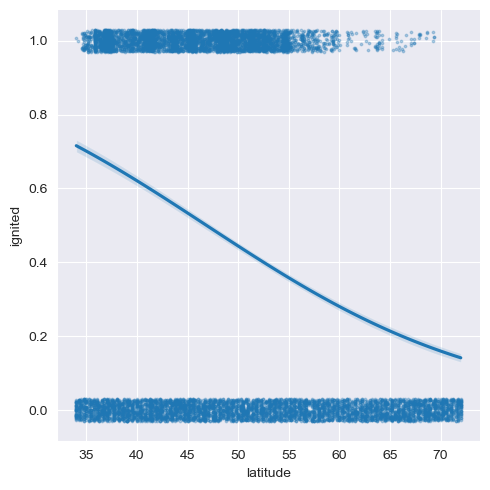

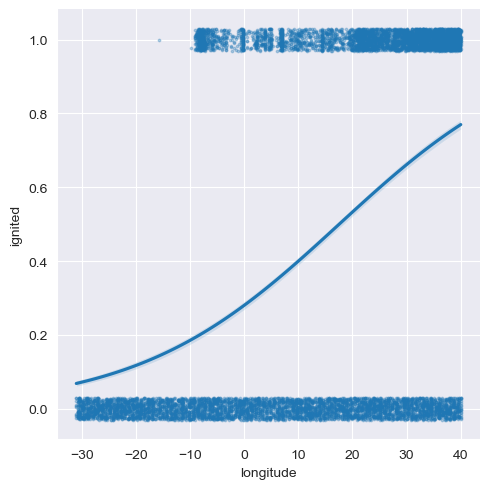

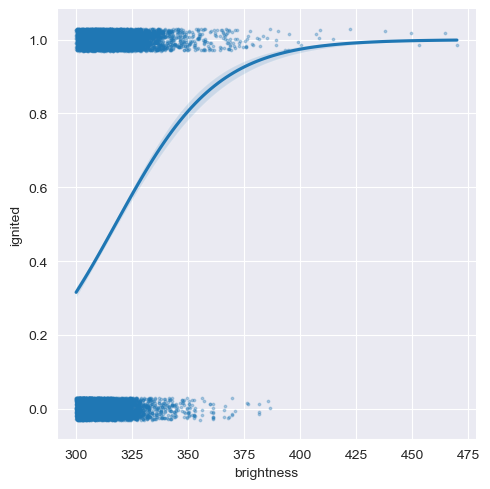

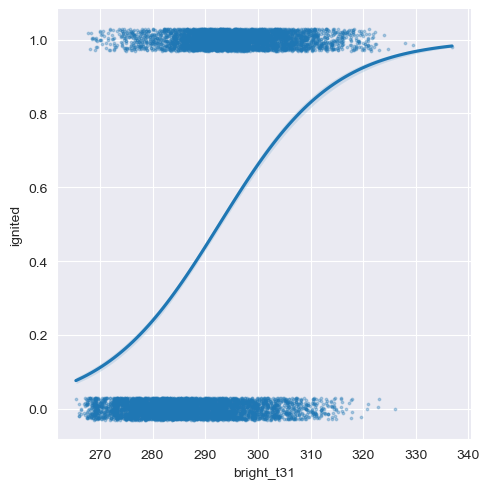

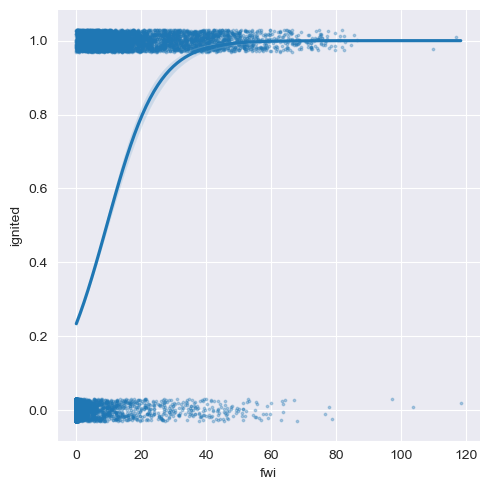

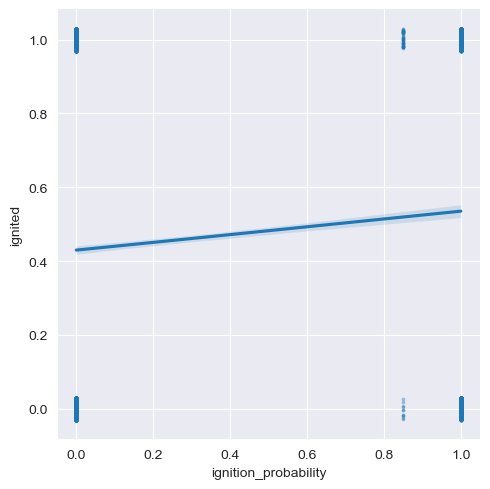

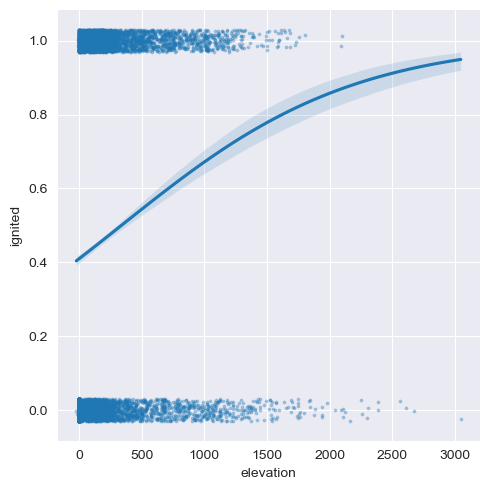

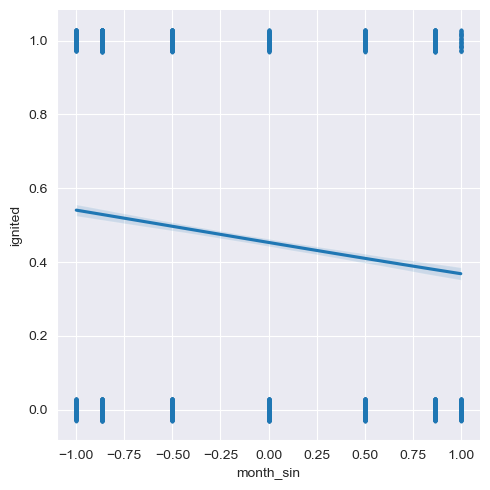

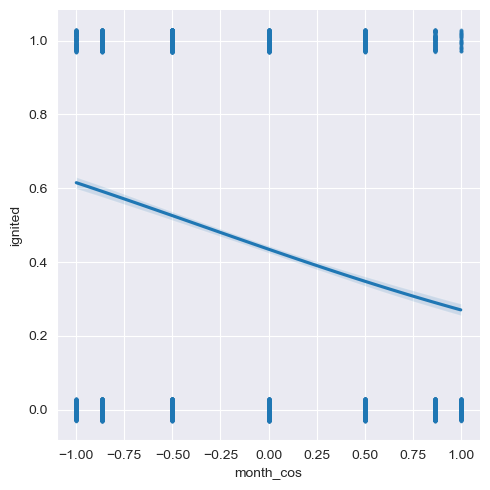

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
for col in df_sub.columns:
    if col != 'ignited':
        sns.lmplot(x=col, y='ignited', data=df_sub, logistic=True, y_jitter=0.03, scatter_kws={'alpha': 0.3, 's': 3})
        plt.show()

In [31]:
correlation_matrix = df.corr()
correlation_matrix

,latitude,longitude,brightness,bright_t31,fwi,ignited,ignition_probability,elevation,month_sin,month_cos
latitude,1.000000,-0.076478,-0.259527,-0.488203,-0.462664,-0.336513,0.024988,-0.276405,0.188376,0.035862
longitude,-0.076478,1.000000,0.061420,0.173126,0.274553,0.455308,0.165127,0.185360,0.014310,-0.115544
brightness,-0.259527,0.061420,1.000000,0.530080,0.428767,0.250383,0.046641,0.139596,-0.208657,-0.245357
bright_t31,-0.488203,0.173126,0.530080,1.000000,0.587817,0.428747,-0.006562,0.199262,-0.348061,-0.500004
fwi,-0.462664,0.274553,0.428767,0.587817,1.000000,0.527461,0.123101,0.357226,-0.349428,-0.298799
ignited,-0.336513,0.455308,0.250383,0.428747,0.527461,1.000000,0.091349,0.171922,-0.136972,-0.239921
ignition_probability,0.024988,0.165127,0.046641,-0.006562,0.123101,0.091349,1.000000,0.374097,0.033665,-0.052752
elevation,-0.276405,0.185360,0.139596,0.199262,0.357226,0.171922,0.374097,1.000000,-0.118798,-0.019143
month_sin,0.188376,0.014310,-0.208657,-0.348061,-0.349428,-0.136972,0.033665,-0.118798,1.000000,-0.055857
month_cos,0.035862,-0.115544,-0.245357,-0.500004,-0.298799,-0.239921,-0.052752,-0.019143,-0.055857,1.000000


<Axes: >

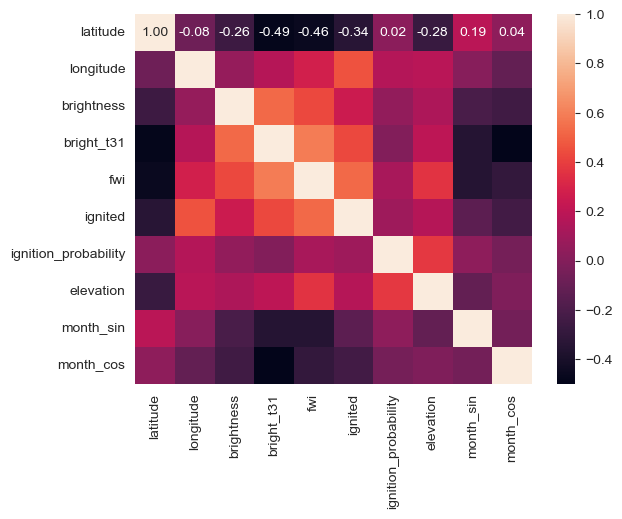

In [32]:
sns.heatmap(df.corr(), annot=True, fmt=".2f")